In [1]:
import numpy as np
import hashlib
import math
import pandas as pd 
import matplotlib.pyplot as plt
import random
import re
import string
from nltk.tokenize import WordPunctTokenizer

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
import spacy


In times where even [facebook goes down](https://www.theguardian.com/technology/2021/oct/04/facebook-instagram-whatsapp-outage-what-to-do), books are our reliable companions. For true book lovers, it's hard to resist the urge to buy huge piles to add to our "To read" lists. But how to know which is the right book to buy?

In any online book store, you can find hundreds of reviews. You also have [goodreads](https://www.goodreads.com/), [book riot](https://bookriot.com/), and many others.



The only problem is that it is hard to navigate through the hundreds and hundreds of reviews, and even if you did have the time, the huge amount of reviews is completely unhelpful. Not to mention the ones that definitely seem posted by bots.

<img src="media/fake-reviews.jpg" width="50%" />


## Q1 - Baseline 

To cope with all of this, you set out to create a model to look for the most helpful reviews for you. You find a dataset online providing reviews and helpfulness metrics and start there.

Load the dataset and check its structure:

In [2]:
def load_data():
    """
    Loads dataframe of reviews helpfulness 
    """
    df = pd.read_csv('datasets/book_review_helpfulness.csv')
    df.head()
    return df

df = load_data()
df.head()

,helpfulness,reviewText
0,1,Old Bear; Kevin Henkes (2008) Harper Collins C...
1,0,This book is based on the sad truth of the sta...
2,1,When Lara's grandmother's ghost begins bashing...
3,1,"Charlotte Simmons is the definitive, classic A..."
4,0,Much too stereotypical for my tastes and the s...


### Q1.a)

First thing you decide to do is to extract features from the reviews. So you start working out how to do it. You think that it may be good to preprocess the text a bit, so you look into a few options. You end up converging to the following:

- tokenizing the text, using WordPunctTokenizer
- lowercasing the text

You then decide to feed this into a CountVectorizer. Implement this function below:

In [3]:
def extract_features(X_train, X_test):
    """Converts the provided text training and test data into 
    feature counts. Additionally, returns the used vectorizer, 
    the processed dataframes and the number of extracted features.
    
    Parameters:
        X_train: dataframe: training data, containing a "reviewText" column
        X_test: dataframe: test data, containing a "reviewText" column
    
    Returns:
        vectorizer: fitted count vectorizer 
        num_features: number of features used by the vectorizer, for a sanity check
        X_train_vec: vectorized training features
        X_test_vec: vectorized test features
    """
    
    vectorizer = CountVectorizer()
    
    # fit the vectorizer on the training data and transform it
    X_train_vec = vectorizer.fit_transform(X_train["reviewText"])
    
    # transform the test data using the fitted vectorizer
    X_test_vec = vectorizer.transform(X_test["reviewText"])
    
    # get the number of features used by the vectorizer
    num_features = len(vectorizer.get_feature_names())
    
    return vectorizer, num_features, X_train_vec, X_test_vec
    


In [4]:
df = load_data()

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['helpfulness']), 
    df['helpfulness'], 
    test_size=0.3, 
    random_state=42
)

vectorizer, num_features, X_train_vec, X_test_vec = extract_features(X_train, X_test)
assert math.isclose(np.sum(X_train_vec.todense()[12, :]), 284), 'The data is not vectorized correctly.'
assert math.isclose(np.sum(X_train_vec.todense()[300, :]), 157), 'The data is not vectorized correctly.'
assert math.isclose(np.sum(X_train_vec.todense()[1411, :]), 222), 'The data is not vectorized correctly.'

assert num_features == 44103, 'The number of features is not correct.'



For the next exercises, we'll provide a different version of the preprocessed data.

Load the preprocessed dataset from the file:

In [5]:
def load_preprocessed_data():
    """
    Loads dataframe of preprocessed helpfulness review 
    """
    preprocessed_df = pd.read_csv('datasets/book_review_helpfulness_preprocessed.csv')
    preprocessed_df.head()
    return preprocessed_df

df_preprocessed = load_preprocessed_data()
df_preprocessed.head()

,helpfulness,reviewText
0,1,old bear kevin henkes harper collins childrenl...
1,0,book based sad truth state country humor berni...
2,1,lara grandmother ghost begins bashing guests f...
3,1,charlotte simmons definitive classic american ...
4,0,much stereotypical tastes storyline unbelievab...


### Q1.b)

You now want to use your newly found features to build a baseline. Create a function that receives your vectorized dataset and trains a naïve Bayes model.

First we'll start by defining a function to obtain precision and recall:

In [6]:
def get_precision_recall(y_test, y_pred):
    """Returns the precision and recall of the helpfulness class (label = 1)
    
    Parameters:
        y_test (Series): Labels corresponding to X_test
        y_pred (Series): Predictions corresponding to X_test

    Returns:
        precision (float): The precision score of the helpfulness class (1) on the test data
        recall (float): The recall score of the helpfulness class (1) on the test data
    """

    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    return precision, recall

Implement below the function to train a naive Bayes model on the vectorized dataset and use the get_precision_recall function to return these metrics over the test set:

In [7]:
def train_model_naive_bayes(X_train_vec, y_train, X_test_vec, y_test):
    """Returns a fitted Multinomial Naive Bayes model, the predictions on the test set
    and the precision and recall scores for these predictions
    
    Parameters:
        X_train_vec (Series): Vectorized text data for training
        y_train (Series): Labels corresponding to X_train
        X_test_vec (Series): Vectorized text data for testing
        y_test (Series): Labels corresponding to X_test

    Returns:
        clf (MultinomialNB): MultinomialNB classifier fitted to the vectorized training data
        y_pred (Series): The predictions computed with our classifier
        precision (float): The precision score of the helpfulness class (1) on the test data
        recall (float): The recall score of the helpfulness class (1) on the test data
    """
    
    clf = MultinomialNB()
    
    # fit the model on the training data
    clf.fit(X_train_vec, y_train)
    
    # make predictions on the test data
    y_pred = clf.predict(X_test_vec)
    
    # get the precision and recall scores
    
    precision,recall = get_precision_recall(y_test, y_pred)
    
    return clf, y_pred, precision, recall

Test your model below:

In [8]:
df = load_data()

cv = CountVectorizer()

X_train, X_test, y_train, y_test = train_test_split(df['reviewText'], df['helpfulness'], test_size=0.2, random_state=42)

cv.fit(X_train)
X_train_vec = cv.transform(X_train)
X_test_vec = cv.transform(X_test)

clf, y_pred, precision, recall = train_model_naive_bayes(X_train_vec, y_train, X_test_vec, y_test)
assert math.isclose(precision, 0.6305625524769102, rel_tol=1e-05), 'Predicted precision is not correct.'
assert math.isclose(recall, 0.689623507805326, rel_tol=1e-05), 'Predicted recall is not correct.'


X_train, X_test, y_train, y_test = train_test_split(df['reviewText'], df['helpfulness'], test_size=0.5, random_state=42)

cv.fit(X_train)
X_train_vec = cv.transform(X_train)
X_test_vec = cv.transform(X_test)

clf, y_pred, precision, recall = train_model_naive_bayes(X_train_vec, y_train, X_test_vec, y_test)
assert math.isclose(precision, 0.6058282208588958, rel_tol=1e-05), 'Predicted precision is not correct.'
assert math.isclose(recall, 0.7391467065868264, rel_tol=1e-05), 'Predicted recall is not correct.'

df_prep = load_preprocessed_data()

X_train, X_test, y_train, y_test = train_test_split(df_prep['reviewText'], df_prep['helpfulness'], test_size=0.2, random_state=42)

cv = CountVectorizer()
cv.fit(X_train)
X_train_vec = cv.transform(X_train)
X_test_vec = cv.transform(X_test)

clf, y_pred, precision, recall = train_model_naive_bayes(X_train_vec, y_train, X_test_vec, y_test)

assert math.isclose(precision, 0.6260032102728732, rel_tol=1e-05), 'Predicted precision is not correct.'
assert math.isclose(recall, 0.7162534435261708, rel_tol=1e-05), 'Predicted recall is not correct.'

Now run the two functions you built with your preprocessed data and check your baseline scores:

In [9]:
df = load_data()

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['helpfulness']), 
    df['helpfulness'], 
    test_size=0.3, 
    random_state=42
)

vectorizer, num_features, X_train_vec, X_test_vec = extract_features(X_train, X_test)
clf, y_pred, precision, recall = train_model_naive_bayes(X_train_vec, y_train, X_test_vec, y_test)
print(f"Number of features: {num_features}")
print(f"Baseline precision: {precision}")
print(f"Baseline recall: {recall}")


Number of features: 44103
Baseline precision: 0.6274292059966685
Baseline recall: 0.7040498442367601


We'll also run with our own preprocessed data so you have a base for comparison.

In [10]:
df_prep = load_preprocessed_data()

X_train, X_test, y_train, y_test = train_test_split(
    df_prep['reviewText'], 
    df_prep['helpfulness'], 
    test_size=0.3, 
    random_state=42
)

cv = CountVectorizer()
cv.fit(X_train)
X_train_vec = cv.transform(X_train)
X_test_vec = cv.transform(X_test)

print(f"Number of features: {len(cv.vocabulary_)}")

clf, y_pred, precision, recall = train_model_naive_bayes(X_train_vec, y_train, X_test_vec, y_test)

print(f"Baseline precision: {precision}")
print(f"Baseline recall: {recall}")


Number of features: 43290
Baseline precision: 0.6101159114857745
Baseline recall: 0.7214953271028037


As we'll use the preprocessed data for the following exercises consider this the baseline:

* Baseline precision: 0.6101159114857745
* Baseline recall: 0.7214953271028037


## Q2) Feature analysis and selection

Those are not bad results to start with, but as you've learned about feature selection you want to try it out. After all, 43 thousand features is still a pretty large number. 


You start with a model based feature selection. For that purpose, you want to use the capability of TF-IDF/CountVectorizer to select the features to use. 

### Q2.a)

Fit a TF-IDF vectorizer with a specific number of features. Note that the features will be selected based on the term frequency, so the resulting vocabulary will be based on the term count. Return these features sorted by inverse document frequency, the other measure used by TF-IDF - as you've seen in the learning notebooks, a measure of whether a term is common or rare in the documents.

Create a function below to:
* train a TF-IDF vectorizer on the provided train data (passing a parameter to define the maximum number of features to use)
* return its features sorted by their inverse document frequency in descending order. 

**Note**: In case of a tie, that is, if several features have the same IDF score, the features should be sorted by alphabetical order.


In [11]:
def get_tfidf_ngrams_sorted_by_idf(X_train, top_features=30):
    """Fits a TfidfVectorizer and returns its features sorted by 
    idf score
    
    Parameters:
        X_train (Series): Vectorized text data for training
        top_features: maximum number of features to use 
    
    Returns:
        vectorizer: used tf-idf vectorizer 
        ngrams_sorted (list): The ngrams of fitted_vectorizer sorted in descending order
                              by their idf score. In case of tie, the features should be sorted 
                              by alphabetical order
    """
    
    
    vectorizer = TfidfVectorizer(max_features=top_features)
    
    vectorizer.fit_transform(X_train)
    
    feature_names = vectorizer.get_feature_names()
    idf = vectorizer.idf_
    
    d = dict(zip(feature_names, idf))
   
    sorted_items = sorted(d.items(), key=lambda x: (-x[1], x[0]))

    sorted_d = dict(sorted_items)

    
    ngrams_sorted = list(sorted_d.keys())
    
    return vectorizer, ngrams_sorted



In [12]:
df_preprocessed = load_preprocessed_data()

vectorizer, sorted_n_grams = get_tfidf_ngrams_sorted_by_idf(df_preprocessed['reviewText'], top_features=100)
assert hashlib.sha256("".join(sorted_n_grams).encode()).hexdigest()=='7297438d39cfaa16f34e06b887d2e26b39234ed6a059ad9b954e32ad9420cc59', 'The features are not correct. Did you sort them correctly?'

Check the features with top inverse document frequency in your vectorizer:

In [13]:
df_preprocessed = load_preprocessed_data()

X_train, X_test, y_train, y_test = train_test_split(
    df_preprocessed['reviewText'], 
    df_preprocessed['helpfulness'], 
    test_size=0.3, 
    random_state=42
)

#show most specifc 30 features of the 100 selected features
vectorizer, sorted_n_grams = get_tfidf_ngrams_sorted_by_idf(X_train, top_features=100)
print('30 most secific features:')
print(sorted_n_grams[:30])

30 most secific features:
['quot', 'war', 'young', 'loved', 'seems', 'stories', 'point', 'must', 'ever', 'old', 'pages', 'different', 'quite', 'come', 'family', 'without', 'last', 'feel', 'times', 'enjoyed', 'enough', 'bit', 'history', 'give', 'right', 'every', 'may', 'part', 'recommend', 'take']


As we're only seeing the top IDF features, they tend to be more specific words you would find only in a subset of the documents. But in general, all of these features are not surprising in the context of books. 

### Q2.b)

Finally we want to see how this behaves in comparison with our baseline. Use the functions you have defined above to try out different values of features (50, 100, 500, 1000, 2000, 5000 and 10000) in the training of a Multinomial Naive Bayes. Check the precision and recall of each run and store it in a list:


In [14]:
df_preprocessed = load_preprocessed_data()

X_train, X_test, y_train, y_test = train_test_split(
    df_preprocessed['reviewText'], 
    df_preprocessed['helpfulness'], 
    test_size=0.3, 
    random_state=42
)
# For the following values: 50, 100, 500, 1000, 2000, 5000 and 10000
# 1. Fit a TF-IDF limiting its features 
# 2. Train a Naive Bayes model
# 3. Obtain precision and recall
# 4. Store the lists of feature length, precision and recall values 
feature_lengths = [50, 100, 500, 1000, 2000, 5000, 10000]
precision_values = []
recall_values = []

for feature in feature_lengths:
    vectorizer = TfidfVectorizer(max_features=feature)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    clf = MultinomialNB()
    clf.fit(X_train_vec, y_train)
    
    y_pred = clf.predict(X_test_vec)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)

    precision_values.append(precision)
    recall_values.append(recall)


In [15]:
assert len(feature_lengths) == len(precision_values) == len(recall_values) == 7, 'Did you use all the proposed numbers of features?'

assert math.isclose(precision_values[4], 0.6114101184068891, rel_tol=1e-05), 'Some precision values are not correct.'
assert math.isclose(recall_values[5], 0.7171339563862928, rel_tol=1e-05), 'Some recall values are not correct.'

assert math.isclose(np.sum(precision_values), 4.170958590158336, rel_tol=1e-05), 'Some precision values are not correct.'
assert math.isclose(np.sum(recall_values), 5.242990654205607, rel_tol=1e-05), 'Some recall values are not correct.'


Look at the precision and recall variation with the number of features and answer the questions below:

In [16]:
for n_features, precision, recall in zip(feature_lengths, precision_values, recall_values):
    print(f"Number of features: {n_features}")
    print(f"Precision: {precision}")    
    print(f"Recall: {recall}")
    print("==============================")


Number of features: 50
Precision: 0.5735359856951274
Recall: 0.7993769470404984
Number of features: 100
Precision: 0.5740824648844586
Recall: 0.7894080996884735
Number of features: 500
Precision: 0.5925
Recall: 0.7383177570093458
Number of features: 1000
Precision: 0.6041666666666666
Recall: 0.7227414330218068
Number of features: 2000
Precision: 0.6114101184068891
Recall: 0.7077881619937695
Number of features: 5000
Precision: 0.6132125732551944
Recall: 0.7171339563862928
Number of features: 10000
Precision: 0.60205078125
Recall: 0.7682242990654206


**Q2.b.i)** Which number of features yielded the **highest precision**?

In [17]:
num_features_highest_precision = 5000

In [18]:
assert hashlib.sha256(bytes(num_features_highest_precision)).hexdigest() == \
    "7ca5bd879f393d9dd05b14f38add9c0fc6b67928f7f2d261b2e47a32ee8219e3"

**Q2.b.ii)** Which number of features yielded the **highest recall**?

In [19]:
num_features_highest_recall = 50


In [20]:
assert hashlib.sha256(bytes(num_features_highest_recall)).hexdigest() == \
    "cc2786e1f9910a9d811400edcddaf7075195f7a16b216dcbefba3bc7c4f2ae51"

**Q2.b.iii)** Which number of features yielded the **highest F1-score**?

In [21]:
num_features_highest_f1 = 10000

In [22]:
assert hashlib.sha256(bytes(num_features_highest_f1)).hexdigest() == \
    "95b532cc4381affdff0d956e12520a04129ed49d37e154228368fe5621f0b9a2"

**Q2.b.iv)** Knowing that you won't be able to read that many reviews, but you want to make sure the ones you do read are helpful, which model would you choose - the one with the highest precision, recall, or f1-score? 

In [23]:
choice_model = 'precision' #, 'recall', 'f1-score'


In [24]:
assert hashlib.sha256(choice_model.encode()).hexdigest() == \
    '68c2f9ee314749c05c96df0cad305b0972506d78bb9b23c942cf805b274236c6'

### Q2.c)

You also heard about Chi squared, another method that selects the best features based on their relevance.

<img src="media/chi-squared-not-sure.jpg" width="400" />

You decide to implement a function to run chi-squared over your vectorizer and return the selected features.

**Note**: In this case, don't limit CountVectorizer/TfidfVectorizer to any number of features

In [25]:
def extract_features_chi2(X_train, y_train, top_features=100, vectorizer_type="count"):
    """Converts the provided text training data into feature counts. 
    Additionally, selects the best features with the chi squared method and returns
    the sorted ngrams
    
    Parameters:
        X_train: training data
        y_train: training labels
        top_features: number of best features to select with the chi squared test
        vectorizer_type: type of vectorizer to use ("count" or "tfidf")

    Returns:
        vectorizer: fitted vectorizer 
        ch2: fitted feature selector
        X_train_ch2: transformed vector after feature selection
        ngrams_sorted (list): the top features of the fitted vectorizer sorted in descending order
                              by their chi squared score
    """
    
    # Initialize the vectorizer
    if vectorizer_type == "count":
        vectorizer = CountVectorizer()
    elif vectorizer_type == "tfidf":
        vectorizer = TfidfVectorizer()
    else:
        raise ValueError("Invalid vectorizer_type. Must be 'count' or 'tfidf'.")
        
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Initialize the chi squared feature selector
    ch2 = SelectKBest(chi2, k=top_features)
    
    # Fit the feature selector on the vectorized training data and target labels
    X_train_ch2 = ch2.fit_transform(X_train_vec, y_train)
       
    # Get the feature names of the selected features
    feature_names = vectorizer.get_feature_names()
    feature_scores = ch2.scores_
    
    # Create a dataframe of feature names and their corresponding chi squared scores
    features = pd.DataFrame({"feature": feature_names, "score": feature_scores})
    
    # Sort the features by their chi squared scores
    features.sort_values(by=["score", "feature"], ascending=[False, True], inplace=True)
    
    # Get the top features
    ngrams_sorted = features["feature"].tolist()[:top_features]
    
    return vectorizer, ch2, X_train_ch2, ngrams_sorted

In [26]:
vectorizer_ch2, ch2, X_train_ch2, most_important_features  = extract_features_chi2(X_train, y_train, vectorizer_type="count", top_features=123)
most_important_features

['book',
 'story',
 'one',
 'life',
 'quot',
 'also',
 'world',
 'well',
 'first',
 'people',
 'novel',
 'time',
 'years',
 'even',
 'reader',
 'many',
 'two',
 'mother',
 'make',
 'young',
 'new',
 'like',
 'much',
 'work',
 'find',
 'stories',
 'may',
 'home',
 'family',
 'us',
 'way',
 'man',
 'living',
 'several',
 'town',
 'old',
 'author',
 'set',
 'characters',
 'house',
 'together',
 'part',
 'takes',
 'little',
 'war',
 'help',
 'read',
 'history',
 'sometimes',
 'wright',
 'series',
 'wife',
 'children',
 'day',
 'still',
 'seem',
 'english',
 'end',
 'makes',
 'quite',
 'ben',
 'century',
 'would',
 'lot',
 'found',
 'see',
 'others',
 'best',
 'text',
 'want',
 'human',
 'woman',
 'good',
 'place',
 'readers',
 'become',
 'events',
 'personal',
 'times',
 'year',
 'given',
 'marriage',
 'great',
 'page',
 'character',
 'issues',
 'john',
 'get',
 'although',
 'long',
 'friend',
 'lives',
 'section',
 'father',
 'white',
 'death',
 'live',
 'friends',
 'love',
 'change',
 'f

In [27]:
df_preprocessed = load_preprocessed_data()

X_train, X_test, y_train, y_test = train_test_split(
    df_preprocessed['reviewText'], 
    df_preprocessed['helpfulness'], 
    test_size=0.3, 
    random_state=42
)

vectorizer_ch2, ch2, X_train_ch2, most_important_features = extract_features_chi2(X_train, y_train, vectorizer_type="tfidf")
assert math.isclose(np.sum(X_train_ch2.todense()[12, :]), 0.30615842862660636, rel_tol=1e-05), 'The transformed train data is not correct.'
assert ch2.k == 100

vectorizer_ch2, ch2, X_train_ch2, most_important_features = extract_features_chi2(X_train, y_train, vectorizer_type="tfidf", top_features=123)
assert math.isclose(np.sum(X_train_ch2.todense()[:, 122]), 33.74087286012022, rel_tol=1e-05), 'The transformed train data is not correct.'
assert ch2.k == 123

vectorizer_ch2, ch2, X_train_ch2, most_important_features = extract_features_chi2(X_train, y_train, vectorizer_type="count")
assert math.isclose(np.sum(X_train_ch2.todense()[12, :]), 26), 'The transformed train data is not correct.'
assert ch2.k == 100

vectorizer_ch2, ch2, X_train_ch2, most_important_features  = extract_features_chi2(X_train, y_train, vectorizer_type="count", top_features=123)

assert math.isclose(np.sum(X_train_ch2.todense()[:, 122]), 734), 'The transformed train data is not correct.'
assert ch2.k == 123

assert len(most_important_features) == 123, 'The amount of features returned is wrong'
assert hashlib.sha256("".join(most_important_features).encode()).hexdigest()=='e2916147e2331b8b69e9bcab86285ed3b8eafe1ddd6def92fd39a19a528e9f13', 'The most important feature list is not correct. Have you sorted them correctly?'

Let's apply our feature extractor with 30 features and check them out:

In [28]:
df_preprocessed = load_preprocessed_data()

X_train, X_test, y_train, y_test = train_test_split(
    df_preprocessed['reviewText'], 
    df_preprocessed['helpfulness'], 
    test_size=0.3, 
    random_state=42
)

vectorizer_ch2, ch2, X_train_ch2, most_important_features  = extract_features_chi2(X_train, y_train, top_features=30)

most_important_features

['book',
 'story',
 'one',
 'life',
 'quot',
 'also',
 'world',
 'well',
 'first',
 'people',
 'novel',
 'time',
 'years',
 'even',
 'reader',
 'many',
 'two',
 'mother',
 'make',
 'young',
 'new',
 'like',
 'much',
 'work',
 'find',
 'stories',
 'may',
 'home',
 'family',
 'us']

We can also see how often each of the selected features appears in the reviews:

In [29]:
for feature in most_important_features:
    print('Documents that contains the word(s) "%s"' % feature)
    print('----')
    docs = X_train.str.lower().str.contains(feature)
    print(str(y_train[docs].value_counts()) + '\n\n')

Documents that contains the word(s) "book"
----
1    3063
0    2507
Name: helpfulness, dtype: int64


Documents that contains the word(s) "story"
----
1    1705
0    1164
Name: helpfulness, dtype: int64


Documents that contains the word(s) "one"
----
1    2537
0    1710
Name: helpfulness, dtype: int64


Documents that contains the word(s) "life"
----
1    1045
0     565
Name: helpfulness, dtype: int64


Documents that contains the word(s) "quot"
----
1    272
0    134
Name: helpfulness, dtype: int64


Documents that contains the word(s) "also"
----
1    937
0    522
Name: helpfulness, dtype: int64


Documents that contains the word(s) "world"
----
1    745
0    375
Name: helpfulness, dtype: int64


Documents that contains the word(s) "well"
----
1    1224
0     710
Name: helpfulness, dtype: int64


Documents that contains the word(s) "first"
----
1    1079
0     634
Name: helpfulness, dtype: int64


Documents that contains the word(s) "people"
----
1    839
0    487
Name: helpfulness,

It seems that most features selected as relevant are slightly more attached to the "helpful" class (1).

Now let's see how the feature selection with chi squared translates to model training. Repeat the procedure you've done in Q2b to check the precision and recall of the models with chi squared selected features. Do that with the function you just created using the count vectorizer and chi-squared.

In [30]:
df_preprocessed = load_preprocessed_data()

X_train, X_test, y_train, y_test = train_test_split(
    df_preprocessed['reviewText'], 
    df_preprocessed['helpfulness'], 
    test_size=0.3, 
    random_state=42
)

# For the following values: 50, 100, 500, 1000, 2000, 5000 and 10000
# 1. Use the count vectorizer and ch2 feature selection with the given number of features 
# 2. Train a Naive Bayes model
# 3. Obtain precision and recall
# 4. Store the lists of feature length, precision and recall values 

feature_lengths = [50, 100, 500, 1000, 2000, 5000, 10000]
precision_values = []
recall_values = []

# Iterate over the different feature values
for feature in feature_lengths:
    # Use the count vectorizer and ch2 feature selection with the given number of features
    vectorizer, ch2, X_train_ch2, ngrams_sorted = extract_features_chi2(X_train, y_train, top_features=feature)
    X_test_ch2 = ch2.transform(vectorizer.transform(X_test))
    
    # Train a Naive Bayes model
    clf = MultinomialNB()
    clf.fit(X_train_ch2, y_train)
    
    # Obtain precision and recall
    y_pred = clf.predict(X_test_ch2)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Store the lists of feature length, precision and recall values
    precision_values.append(precision)
    recall_values.append(recall)

In [31]:
assert len(feature_lengths) == len(precision_values) == len(recall_values) == 7, 'Did you use all the proposed feature counts?'

assert math.isclose(precision_values[4], 0.649458784346378, rel_tol=1e-05), 'Some precision values are not correct.'
assert math.isclose(recall_values[5], 0.49221183800623053, rel_tol=1e-05), 'Some recall values are not correct.'

assert math.isclose(np.sum(precision_values), 4.416826519514508, rel_tol=1e-05), 'Some precision values are not correct.'
assert math.isclose(np.sum(recall_values), 3.5514018691588785, rel_tol=1e-05), 'Some recall values are not correct.'

Finally, check the precision and recall scores:

In [32]:
for n_features, precision, recall in zip(feature_lengths, precision_values, recall_values):
    print(f"Number of features: {n_features}")
    print(f"Precision: {precision}")    
    print(f"Recall: {recall}")
    print("==============================")

Number of features: 50
Precision: 0.5874079035498996
Recall: 0.5464174454828661
Number of features: 100
Precision: 0.6043795620437956
Recall: 0.5158878504672897
Number of features: 500
Precision: 0.630016051364366
Recall: 0.48909657320872274
Number of features: 1000
Precision: 0.6371753246753247
Recall: 0.48909657320872274
Number of features: 2000
Precision: 0.649458784346378
Recall: 0.48598130841121495
Number of features: 5000
Precision: 0.661641541038526
Recall: 0.49221183800623053
Number of features: 10000
Precision: 0.6467473524962178
Recall: 0.5327102803738317


In this case, we were able to raise precision (check the values for 5000 features) even though we sacrificed recall.

## Q3.

Now let's move on to more complex feature selection methods. In the previous methods, the selection is based on the actual n-grams, so we are limited to the information each feature brings in separately. We will now try PCA, which will find the principal components of our vectorized representation.

Write a function that computes PCA on top of a CountVectorizer. Calculate the total variance explained by the PCA components (hint: use an attribute of PCA). Additionally, train a Support Vector Classifier on top of the PCA output.

**To avoid using too much memory, and as we'll use dense matrices, please use a max_features value of 5000 in the vectorizer.**

In [33]:
def train_model_pca_svm(X_train, y_train, X_test, y_test, num_features=100, seed=42):
    """Returns a fitted CountVectorizer, the PCA, a support vector classifier
    and the test predictions computed with these
    
    Parameters:
        X_train (Series): Text data for training
        y_train (Series): Labels corresponding to X_train
        X_test (Series): Text data for testing
        y_test (Series): Labels corresponding to X_test
        num_features (int): number of features to use in the PCA
        seed (int): Seed to use for random state in PCA

    Returns:
        vectorizer (CountVectorizer): CountVectorizer, fitted to X_train
        pca (PCA): fitted PCA with the given number of components
        clf (SVC): SVC classifier fitted to the PCA transformed training data
        y_pred (Series): The predictions computed with the SVC classifier
        explained_variance(float): variance in the data explained by all the PCA components together
    """
    # Initialize the count vectorizer
    vectorizer = CountVectorizer(max_features=5000)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    pca = PCA(n_components=num_features, random_state=42)
    
    dense_X_train = X_train_vec.toarray()
    dense_X_test = X_test_vec.toarray()
    data_var = np.var(dense_X_train, axis=0).sum()

    
    pca.fit(dense_X_train)
    
    X_train_pca = pca.transform(dense_X_train)
    X_test_pca = pca.transform(dense_X_test)
    explained_variance = (1.0*np.var(X_train_pca, axis=0).sum() / data_var)
    
    
    # Initialize the SVC classifier
    clf = SVC(random_state=42)
    
    # Fit the classifier on the PCA transformed training data
    clf.fit(X_train_pca, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(X_test_pca)
    
    return vectorizer, pca, clf, y_pred, explained_variance

In [34]:
df_preprocessed = load_preprocessed_data()

X_train, X_test, y_train, y_test = train_test_split(
    df_preprocessed['reviewText'], 
    df_preprocessed['helpfulness'], 
    test_size=0.3, 
    random_state=42
)

vectorizer, pca, clf, y_pred_30, variance_30 = train_model_pca_svm(X_train, y_train, X_test, y_test, num_features=30, seed=42)
print("----- Computed PCA for 30 features -----\n")
assert np.mean(y_pred_30) == 0.5516666666666666, 'The prediction is not correct.'
assert np.sum(y_pred_30) == 1655, 'The prediction is not correct.'
assert pca.n_components == 30, 'The number of PCA components should be 30'
assert vectorizer.get_feature_names()[4424] == 'teaching', 'The features are not correctly vectorized.'

vectorizer, pca, clf, y_pred_50, variance_50 = train_model_pca_svm(X_train, y_train, X_test, y_test, num_features=50, seed=42)
print("----- Computed PCA for 50 features -----\n")
assert np.mean(y_pred_50) == 0.5416666666666666, 'The prediction is not correct.'
assert np.sum(y_pred_50) == 1625, 'The prediction is not correct.'
assert pca.n_components == 50, 'The number of PCA components should be 30'
assert vectorizer.get_feature_names()[4424] == 'teaching', 'The features are not correctly vectorized.'

vectorizer, pca, clf, y_pred_100, variance_100 = train_model_pca_svm(X_train, y_train, X_test, y_test, num_features=100, seed=42)
print("----- Computed PCA for 100 features -----\n")
assert np.mean(y_pred_100) == 0.544, 'The prediction is not correct.'
assert np.sum(y_pred_100) == 1632, 'The prediction is not correct.'
assert pca.n_components == 100, 'The number of PCA components should be 30'
assert vectorizer.get_feature_names()[4424] == 'teaching','The features are not correctly vectorized.'

----- Computed PCA for 30 features -----

----- Computed PCA for 50 features -----

----- Computed PCA for 100 features -----



We can compare the new precision and recall with the previous results:

In [35]:
precision, recall = get_precision_recall(y_test, y_pred_30)     
print("\nPredictions with 30 features: ")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("Explained variance: {}".format(variance_30))

precision, recall = get_precision_recall(y_test, y_pred_50)      
print("\nPredictions with 50 features: ")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("Explained variance: {}".format(variance_50))

precision, recall = get_precision_recall(y_test, y_pred_100)     
print("\nPredictions with 100 features: ")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("Explained variance: {}".format(variance_100))


Predictions with 30 features: 
Precision: 0.656797583081571
Recall: 0.6772585669781932
Explained variance: 0.25141775667013727

Predictions with 50 features: 
Precision: 0.6646153846153846
Recall: 0.6728971962616822
Explained variance: 0.3068693235464023

Predictions with 100 features: 
Precision: 0.6611519607843137
Recall: 0.6722741433021807
Explained variance: 0.400755911573683


Nice! We kept the high precision of the chi squared feature selection method but with a much higher recall.

## Q4.

Now we'll change gears a bit and look into word vectors. In Learning Notebook 3 we told you that word vectors can be visualized after being projected into 2D space, and we showed you this diagram:

<img src="./media/word-vectors-projection.png" width="600">

Now we'll try to combine what you've learned about word embeddings and PCA to make our own visualization.

In [36]:
# load word embeddings

nlp = spacy.load('en_core_web_md')

### Q4.a)

First, to get comfortable with spacy, get the vector for the word "book".

In [37]:
book_vector = nlp("book").vector


In [38]:
assert book_vector.shape[0] == 300, 'The size of the vector is not correct.'
assert math.isclose(book_vector.sum(), -8.673375, abs_tol=0.0001) #'This is not the correct vector.'


### Q4.b) 

Next, write a function that uses sklearn's PCA to reduce the word vectors to a convenient number of dimensions for plotting. The function should return the reduced dimension word vectors.

In [39]:
def reduce_word_vecs(vectors, random_state):
    """
    Returns PCA-reduced word vectors of the input vectors for plotting
    
    Parameters:
        vectors (np.array): Word vectors to be reduced
        random_state (int): random state to use in PCA

    Returns:
        reduced_vecs (np.array): Word vectors reduced to the number of dimensions
                                 suitable for plotting
    """
    pca = PCA(n_components=2, random_state=random_state)
    pca.fit(vectors)
    reduced_vecs = pca.transform(vectors)
    
    return reduced_vecs

In [40]:
test_vectors = np.array([[0.1, 0.2, 0.3, 0.4], [0.3, 0.5, 0.1, 0.7], [0.8, 0.6, 0.2, 0.4]])
reduced_vecs = reduce_word_vecs(test_vectors, random_state=42)

assert reduced_vecs.shape == (3,2), 'Did you choose the correct number of dimensions for the vectors?'
assert math.isclose(reduced_vecs[1][1], 0.24736592153367926, rel_tol=1e-05), 'Some vectors are not reduced correctly.' 
assert math.isclose(reduced_vecs[2][0], 0.43388622222454437, rel_tol=1e-05), 'Some vectors are not reduced correctly.' 

Now we'll create an array of ~75,000 of spacy's word vectors and use your function to reduce them. If you're curious about using the full amount of word vectors, you can change the code to iterate over all vocab words - `list(nlp.vocab.strings)` - instead of our own `vocab_strings`, but beware that it will use a lot of memory!

We'll also create a list of words that we'll plot later.

In [41]:
#words to plot later with reduced word vectors 
words_to_plot = ['banana', 'pineapple', 'mango', 'red', 'blue', 'yellow', 'woman', 'man', 'child', 'playing',
                 'reading', 'studying', 'nintendo', 'sony', 'xbox', 'sad', 'angry', 'bored']

In [42]:
#reduce a subset of spacy word vectors
with open('datasets/word_subset.txt') as fwords:
    vocab_strings = fwords.read().splitlines()

full_vocab_vecs = []
for tok in vocab_strings:
    full_vocab_vecs.append(nlp.vocab.get_vector(tok))

vocab_array = np.array(full_vocab_vecs)

In [43]:
print('Word vectors shape pre-PCA: {}'.format(vocab_array.shape))

full_vocab_reduced = reduce_word_vecs(vocab_array, random_state=42)

print('Word vectors shape after PCA: {}'.format(full_vocab_reduced.shape))

Word vectors shape pre-PCA: (103202, 300)
Word vectors shape after PCA: (103202, 2)


Time to plot! For this, we'll create a subset of the word vectors.

In [44]:
#create a list of word vectors for the words_to_plot list
coords = []
for word in words_to_plot:
    idx = vocab_strings.index(word)
    coords.append(full_vocab_reduced[idx])

coords_array = np.array(coords)

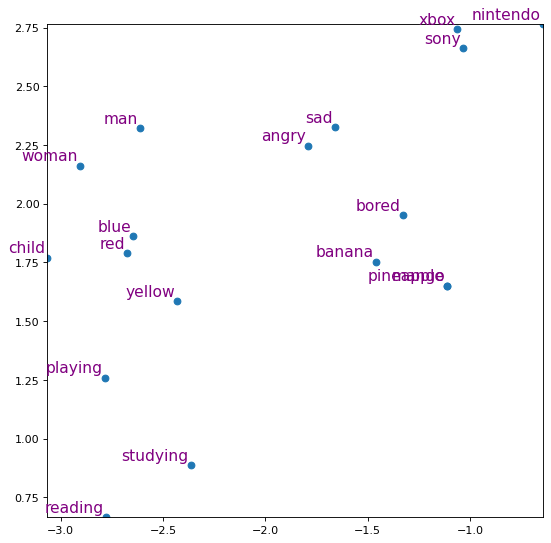

In [45]:
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
min_x=min([x for x in coords_array[:,0]])
max_x=max([x for x in coords_array[:,0]])
min_y=min([y for y in coords_array[:,1]])
max_y=max([y for y in coords_array[:,1]])
plt.xlim(min_x,max_x)
plt.ylim(min_y,max_y)
plt.scatter(coords_array[:,0], coords_array[:,1])
plt.plot([0,0],[min_y,max_y],'--',lw=0.7,c='lightblue')
plt.plot([min_x,max_x],[0,0],'--',lw=0.7,c='lightblue')
for item, x, y in zip(words_to_plot, coords_array[:,0], coords_array[:,1]):
    plt.annotate(item, xy=(x, y), xytext=(-2, 2), textcoords='offset points', 
                 ha='right', va='bottom', color='purple', fontsize=14 )
plt.show()

The PCA has worked! In the diagram, we can see similar types of words closer together. Note that the closeness is measured by the angle between the vectors (from the origin to the blue endpoints). But of course, take these visualizations with a grain of salt because it is practically impossible to preserve all distances in a high dimensional space in just two dimensions.

### Q4.c) 

As a final exercise, we'll look at word similarities.

Write a function that returns the closest word in terms of cosine similarity to a given word. If there are multiple words with the same highest similarity, return all of them. All the words are from the words_to_plot list defined in Q4b and the vectors are the 2D vectors reduced by PCA.

Hint: you can use the already imported `cosine_similarity` function from sklearn to compute cosine similarity.

In [46]:
def closest_word(input_word, words_in_vocab, word_vectors):
    '''Returns a list of the closest words to the input_word from the word_in_vocab list,
       based on cosine similarity of the word vectors
    
    Parameters:
        input_word (string): Search for the closest words to this word 
                             (the input_word is also from the words_in_vocab list)
        words_in_vocab (list): Vocabulary associated with the vectors in word_vectors
        word_vectors (np.array): 2D word vectors associated with the strings in words_in_vocab

    Returns:
        closest_words_list (list): List of strings containing the closest words to the
                                   input_word, based on cosine similarity between the word vectors
    '''
    input_word_vector = word_vectors[words_in_vocab.index(input_word)]
    similarity_scores = np.dot(word_vectors, input_word_vector) / (np.linalg.norm(word_vectors, axis=1) * np.linalg.norm(input_word_vector))
    closest_words_indices = np.argsort(similarity_scores)[-2:][::-1]
    closest_words_list = [words_in_vocab[i] for i in closest_words_indices if words_in_vocab[i] != input_word]
    return closest_words_list




In [47]:
closest_word('playing', words_to_plot, coords_array)

['studying']

In [48]:
assert hashlib.sha256(closest_word('nintendo', words_to_plot, coords_array)[0].encode()).hexdigest() == 'f711da60664c04c146d7a47b722c38a8d0bf46c3f52c2084c5c8d1cb78138e73', 'This is not the closest word to nintendo'
assert hashlib.sha256(closest_word('playing', words_to_plot, coords_array)[0].encode()).hexdigest() ==  '435c149cbc6a5e5cc373cd33347d4c336a22160e06b7df61092b66e56f4d55ec', 'This is not the closest word to playing'
assert hashlib.sha256(closest_word('pineapple', words_to_plot, coords_array)[0].encode()).hexdigest() == '6815f3c300383519de8e437497e2c3e97852fe8d717a5419d5aafb00cb43c494', 'This is not the closest word to pineapple'


In [49]:
print("\nClosest words to nintendo:")
print(closest_word('nintendo', words_to_plot, coords_array))

print("\nClosest words to playing:")
print(closest_word('playing', words_to_plot, coords_array))

print("\nClosest words to pineapple:")
print(closest_word('pineapple', words_to_plot, coords_array))


Closest words to nintendo:
['xbox']

Closest words to playing:
['studying']

Closest words to pineapple:
['mango']


That is all, see you in the next specialization. 

PS: feel free to share your book reviews and recommendations. :)

<img src="media/dont-buy-more-books.jpg" width="50%" />
